# **imports**

In [1]:
!nvidia-smi

Fri Oct  3 19:00:16 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 566.03                 Driver Version: 566.03         CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060 Ti   WDDM  |   00000000:01:00.0  On |                  N/A |
|  0%   41C    P0             29W /  165W |    2272MiB /  16380MiB |      5%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
%pip install torchmetrics

Note: you may need to restart the kernel to use updated packages.


In [3]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split, Dataset

import torchvision
from torchvision import datasets
from torchvision import transforms as T
from torchvision.models import vit_b_16 as ViT
from torchvision.models import resnet34 as ResNet34
from torch.utils.data import Dataset
from torchvision.datasets.utils import download_url

import matplotlib.pyplot as plt
from tqdm import tqdm
from torchmetrics import Accuracy
import os
from PIL import Image

import json

# **dataset**

In [4]:
def expand_if_grayscale(x):
    # 如果只有1個channel才expand
    if x.shape[0] == 1:
        return x.expand(3, -1, -1)
    return x

In [ ]:
transforms = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Lambda(expand_if_grayscale),
    T.Normalize([0.1307], [0.3081])
])
train_data = datasets.EMNIST(root='EMNIST/raw/train-images-idx3-ubyte', split='balanced', train=True, transform=transforms, download=True)
test_data = datasets.EMNIST(root='EMNIST/raw/test-images-idx3-ubyte', split='balanced', train=False, transform=transforms, download=True)
class_number = 47

In [ ]:
transforms = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Lambda(expand_if_grayscale),
    T.Normalize([0.1307, 0.1307, 0.1307], [0.3081, 0.3081, 0.3081])
])
train_data = datasets.CIFAR100(root='CIFAR100', train=True, transform=transforms, download=True)
test_data = datasets.CIFAR100(root='CIFAR100', train=False, transform=transforms, download=True)
class_number = 100

In [5]:
transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

with open(r"C:\Users\User\Downloads\archive\Labels.json", 'r') as f:
    idx2label = json.load(f)

train_data = datasets.ImageFolder(root=r"C:\Users\User\Downloads\archive\train.X", transform=transform)
test_data = datasets.ImageFolder(root=r"C:\Users\User\Downloads\archive\val.X", transform=transform)
class_number = len(train_data.classes)

In [6]:
train_data.class_to_idx

{'n01440764': 0,
 'n01443537': 1,
 'n01484850': 2,
 'n01491361': 3,
 'n01494475': 4,
 'n01496331': 5,
 'n01498041': 6,
 'n01514668': 7,
 'n01514859': 8,
 'n01531178': 9,
 'n01537544': 10,
 'n01560419': 11,
 'n01582220': 12,
 'n01592084': 13,
 'n01601694': 14,
 'n01608432': 15,
 'n01614925': 16,
 'n01622779': 17,
 'n01630670': 18,
 'n01632458': 19,
 'n01632777': 20,
 'n01644900': 21,
 'n01664065': 22,
 'n01665541': 23,
 'n01667114': 24,
 'n01667778': 25,
 'n01675722': 26,
 'n01677366': 27,
 'n01685808': 28,
 'n01687978': 29,
 'n01693334': 30,
 'n01695060': 31,
 'n01698640': 32,
 'n01728572': 33,
 'n01729322': 34,
 'n01729977': 35,
 'n01734418': 36,
 'n01735189': 37,
 'n01739381': 38,
 'n01740131': 39,
 'n01742172': 40,
 'n01749939': 41,
 'n01751748': 42,
 'n01753488': 43,
 'n01755581': 44,
 'n01756291': 45,
 'n01770081': 46,
 'n01770393': 47,
 'n01773157': 48,
 'n01773549': 49,
 'n01773797': 50,
 'n01774384': 51,
 'n01774750': 52,
 'n01775062': 53,
 'n01776313': 54,
 'n01795545': 55,
 '

In [7]:
train_loader = DataLoader(train_data, batch_size=128, shuffle=True, num_workers=4)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False, num_workers=4)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9124069..2.5702832].


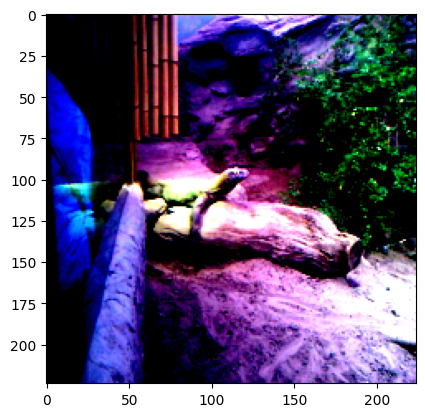

In [9]:
# 取出一個 batch，並取得第一個資料
x, y = next(iter(train_loader))
plt.imshow(x[0].permute(1, 2, 0))

# **ResNet Model**

In [10]:
model = ResNet34(weights=None)
model.fc = nn.Linear(512, class_number)
model.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
model.layer4[0]

BasicBlock(
  (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (downsample): Sequential(
    (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)

# **VGGnet Model Settings**


In [ ]:
def conv2d_bn_prelu(in_channels, out_channels):
  module = nn.Sequential(nn.Conv2d(in_channels, out_channels, 3, padding=1),
                         nn.BatchNorm2d(out_channels),
                         nn.PReLU())
  return module

In [ ]:
def conv2d_7_bn_prelu(in_channels, out_channels):
  module = nn.Sequential(nn.Conv2d(in_channels, out_channels, 7, padding=3, stride=2),
                         nn.BatchNorm2d(out_channels),
                         nn.PReLU())
  return module

# **VGGnet Model**

In [ ]:
#VGGnet-B (13 weight layers)
model = nn.Sequential(conv2d_7_bn_prelu(1,64),# 128*256  ->  64*128
                      conv2d_bn_prelu(64,64),

                      nn.MaxPool2d(3, stride=2, padding=1),#32*64

                      conv2d_bn_prelu(64,128),
                      conv2d_bn_prelu(128,128),

                      nn.MaxPool2d(kernel_size=2, stride=2),#16*32

                      conv2d_bn_prelu(128,256),
                      conv2d_bn_prelu(256,256),

                      nn.MaxPool2d(kernel_size=2, stride=2),#8*16

                      conv2d_bn_prelu(256,512),
                      conv2d_bn_prelu(512,512),

                      nn.MaxPool2d(kernel_size=3,stride=3, padding=1),#4*6

                      conv2d_bn_prelu(512,512),
                      conv2d_bn_prelu(512,512),

                      nn.AdaptiveAvgPool2d(output_size = (1,1)),
                      nn.Flatten(),
                      nn.Linear(512,47))


In [ ]:
#VGGnet-D (16 weight layers)
model = nn.Sequential(conv2d_7_bn_prelu(1,64),# 128*256  ->  64*128
                      conv2d_bn_prelu(64,64),

                      nn.MaxPool2d(3, stride=2, padding=1),#32*64

                      conv2d_bn_prelu(64,128),
                      conv2d_bn_prelu(128,128),

                      nn.MaxPool2d(2,2),#16*32

                      conv2d_bn_prelu(128,256),
                      conv2d_bn_prelu(256,256),
                      conv2d_bn_prelu(256,256),

                      nn.MaxPool2d(2,2),#8*16

                      conv2d_bn_prelu(256,512),
                      conv2d_bn_prelu(512,512),
                      conv2d_bn_prelu(512,512),

                      nn.MaxPool2d(3,stride=3, padding=1),#4*6

                      conv2d_bn_prelu(512,512),
                      conv2d_bn_prelu(512,512),
                      conv2d_bn_prelu(512,512),

                      nn.AdaptiveAvgPool2d(output_size = (1,1)),
                      nn.Flatten(),
                      nn.Linear(512,47))


In [ ]:
#VGGnet-E (19 weight layers)
model = nn.Sequential(conv2d_7_bn_prelu(1,64),# 128*256  ->  64*128
                      conv2d_bn_prelu(64,64),

                      nn.MaxPool2d(3, stride=2, padding=1),#32*64

                      conv2d_bn_prelu(64,128),
                      conv2d_bn_prelu(128,128),

                      nn.MaxPool2d(2,2),#16*32

                      conv2d_bn_prelu(128,256),
                      conv2d_bn_prelu(256,256),
                      conv2d_bn_prelu(256,256),
                      conv2d_bn_prelu(256,256),

                      nn.MaxPool2d(2,2),#8*16

                      conv2d_bn_prelu(256,512),
                      conv2d_bn_prelu(512,512),
                      conv2d_bn_prelu(512,512),
                      conv2d_bn_prelu(512,512),

                      nn.MaxPool2d(3,stride=3, padding=1),#4*6

                      conv2d_bn_prelu(512,512),
                      conv2d_bn_prelu(512,512),
                      conv2d_bn_prelu(512,512),
                      conv2d_bn_prelu(512,512),

                      nn.AdaptiveAvgPool2d(output_size = (1,1)),
                      nn.Flatten(),
                      nn.Linear(512,47))


# **ViT model**

In [ ]:
model = ViT(weights=None)
model.heads.head = nn.Linear(model.heads.head.in_features, class_number)

# **Optimizer**

In [11]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, nesterov=True, weight_decay=1e-4)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)

In [12]:
loss_fn = nn.CrossEntropyLoss()

# **Train**

In [13]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

class AverageMeter(object) :
  def __init__(self):
    self.reset()
  def reset(self) :
    self.avg = 0
    self.val = 0
    self.sum = 0
    self.count = 0
  def update (self, val, n=1) :
    self.val = val
    self.count += n
    self.sum += self.val * n
    self.avg = self.sum / self.count

def train(model, train_loader, optimizer, loss_fn, epoch=None):
  model.train()
  trian_loss = AverageMeter()
  train_acc = Accuracy(task='multiclass', num_classes=class_number).to(device)
  with tqdm(train_loader, unit='batch') as tepoch :
    for inputs, targets in tepoch:
      if epoch is not None:
        tepoch.set_description(f'Epoch {epoch}')
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)
      loss = loss_fn(outputs, targets)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      trian_loss.update(loss.item())
      train_acc(outputs.argmax(dim=1), targets)

      tepoch.set_postfix(loss=trian_loss.avg,
                         accuracy=100*train_acc.compute().item())
    return model, trian_loss.avg, train_acc.compute()

def evaluate (model, test_loader, loss_fn):
  model.eval()
  with torch.no_grad():
    test_loss = AverageMeter()
    test_acc = Accuracy(task='multiclass', num_classes=class_number).to(device)
    for n, (inputs, targets) in enumerate(test_loader):
      inputs =  inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)
      loss = loss_fn(outputs, targets)

      test_loss.update(loss)
      test_acc(outputs, targets)
      return test_loss.avg, test_acc.compute()
    

loss_train_hist = []
loss_valid_hist = []

acc_train_hist = []
acc_valid_hist = []

In [14]:
epoch_number = 30

for epoch in range(epoch_number):
  model, train_loss, train_acc = train(model, train_loader, optimizer, loss_fn, epoch)

  test_loss, test_acc = evaluate(model, test_loader, loss_fn)
  loss_train_hist.append(train_loss)
  loss_valid_hist.append(test_loss.to('cpu'))

  acc_train_hist.append(train_acc.to('cpu'))
  acc_valid_hist.append(test_acc.to('cpu'))
  print(f'Test - Loss:{test_loss} - Accuracy:{test_acc}')
  print()

Epoch 0: 100%|██████████| 1016/1016 [06:42<00:00,  2.52batch/s, accuracy=7.1, loss=4.14] 


Test - Loss:2.6532630920410156 - Accuracy:0.3671875



Epoch 1: 100%|██████████| 1016/1016 [06:46<00:00,  2.50batch/s, accuracy=16.8, loss=3.48]


Test - Loss:2.877174139022827 - Accuracy:0.296875



Epoch 2: 100%|██████████| 1016/1016 [06:46<00:00,  2.50batch/s, accuracy=25.4, loss=3.02]


Test - Loss:2.0503594875335693 - Accuracy:0.4765625



Epoch 3: 100%|██████████| 1016/1016 [06:48<00:00,  2.49batch/s, accuracy=31.9, loss=2.69]


Test - Loss:2.032442569732666 - Accuracy:0.4453125



Epoch 4: 100%|██████████| 1016/1016 [06:47<00:00,  2.49batch/s, accuracy=36.9, loss=2.45]


Test - Loss:1.9502032995224 - Accuracy:0.5078125



Epoch 5: 100%|██████████| 1016/1016 [06:41<00:00,  2.53batch/s, accuracy=41.3, loss=2.25]


Test - Loss:1.3293514251708984 - Accuracy:0.7265625



Epoch 6: 100%|██████████| 1016/1016 [06:45<00:00,  2.50batch/s, accuracy=45, loss=2.08] 


Test - Loss:1.4434499740600586 - Accuracy:0.6015625



Epoch 7: 100%|██████████| 1016/1016 [06:46<00:00,  2.50batch/s, accuracy=48.2, loss=1.94]


Test - Loss:1.1169432401657104 - Accuracy:0.6640625



Epoch 8: 100%|██████████| 1016/1016 [06:45<00:00,  2.51batch/s, accuracy=51.2, loss=1.81]


Test - Loss:1.2379738092422485 - Accuracy:0.671875



Epoch 9: 100%|██████████| 1016/1016 [06:43<00:00,  2.52batch/s, accuracy=54.2, loss=1.7]


Test - Loss:0.9601531624794006 - Accuracy:0.7421875



Epoch 10: 100%|██████████| 1016/1016 [06:43<00:00,  2.52batch/s, accuracy=56.8, loss=1.59]


Test - Loss:0.8997337818145752 - Accuracy:0.7421875



Epoch 11: 100%|██████████| 1016/1016 [06:41<00:00,  2.53batch/s, accuracy=59.2, loss=1.48]


Test - Loss:1.4337743520736694 - Accuracy:0.625



Epoch 12: 100%|██████████| 1016/1016 [06:42<00:00,  2.52batch/s, accuracy=61.8, loss=1.38]


Test - Loss:1.5629037618637085 - Accuracy:0.6328125



Epoch 13: 100%|██████████| 1016/1016 [06:42<00:00,  2.52batch/s, accuracy=64.2, loss=1.28]


Test - Loss:0.7146146893501282 - Accuracy:0.7890625



Epoch 14: 100%|██████████| 1016/1016 [06:41<00:00,  2.53batch/s, accuracy=66.8, loss=1.17]


Test - Loss:0.7753961682319641 - Accuracy:0.78125



Epoch 15: 100%|██████████| 1016/1016 [06:41<00:00,  2.53batch/s, accuracy=69.4, loss=1.07]


Test - Loss:0.9261232018470764 - Accuracy:0.765625



Epoch 16: 100%|██████████| 1016/1016 [06:42<00:00,  2.53batch/s, accuracy=72.2, loss=0.965]


Test - Loss:0.8745532035827637 - Accuracy:0.7734375



Epoch 17: 100%|██████████| 1016/1016 [06:43<00:00,  2.51batch/s, accuracy=74.9, loss=0.862]


Test - Loss:0.9841691255569458 - Accuracy:0.7109375



Epoch 18: 100%|██████████| 1016/1016 [06:43<00:00,  2.52batch/s, accuracy=77.6, loss=0.758]


Test - Loss:1.0483932495117188 - Accuracy:0.6953125



Epoch 19: 100%|██████████| 1016/1016 [06:41<00:00,  2.53batch/s, accuracy=80.4, loss=0.661]


Test - Loss:1.2201638221740723 - Accuracy:0.703125



Epoch 20: 100%|██████████| 1016/1016 [06:41<00:00,  2.53batch/s, accuracy=83.2, loss=0.566]


Test - Loss:1.0518581867218018 - Accuracy:0.7265625



Epoch 21: 100%|██████████| 1016/1016 [06:43<00:00,  2.52batch/s, accuracy=85.8, loss=0.479]


Test - Loss:1.6897286176681519 - Accuracy:0.6015625



Epoch 22: 100%|██████████| 1016/1016 [06:42<00:00,  2.53batch/s, accuracy=88.1, loss=0.402]


Test - Loss:1.2320176362991333 - Accuracy:0.671875



Epoch 23: 100%|██████████| 1016/1016 [06:42<00:00,  2.53batch/s, accuracy=90, loss=0.342] 


Test - Loss:1.5261621475219727 - Accuracy:0.6328125



Epoch 24: 100%|██████████| 1016/1016 [06:41<00:00,  2.53batch/s, accuracy=91.9, loss=0.28]


Test - Loss:1.5974773168563843 - Accuracy:0.625



Epoch 25: 100%|██████████| 1016/1016 [06:41<00:00,  2.53batch/s, accuracy=93.4, loss=0.236]


Test - Loss:0.9911046624183655 - Accuracy:0.7109375



Epoch 26: 100%|██████████| 1016/1016 [06:42<00:00,  2.53batch/s, accuracy=94.6, loss=0.199]


Test - Loss:1.0573837757110596 - Accuracy:0.734375



Epoch 27: 100%|██████████| 1016/1016 [06:41<00:00,  2.53batch/s, accuracy=96, loss=0.157]  


Test - Loss:0.9790438413619995 - Accuracy:0.7421875



Epoch 28: 100%|██████████| 1016/1016 [06:41<00:00,  2.53batch/s, accuracy=96.7, loss=0.131]


Test - Loss:1.4451947212219238 - Accuracy:0.6484375



Epoch 29: 100%|██████████| 1016/1016 [06:42<00:00,  2.52batch/s, accuracy=97.3, loss=0.11] 


Test - Loss:1.5593348741531372 - Accuracy:0.65625



# **Plot**

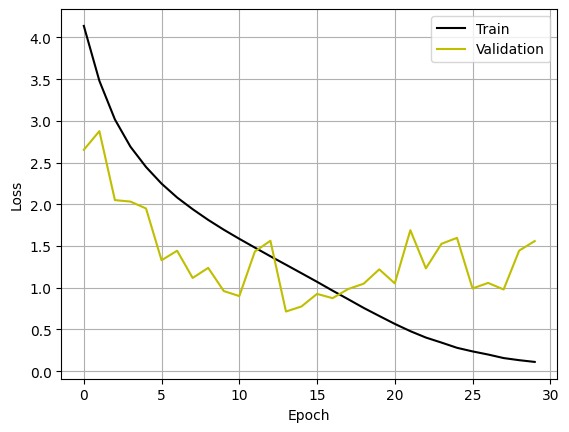

In [16]:
avg_epoch = 30
plt.plot(range(avg_epoch), loss_train_hist, 'k-', label="Train",)
plt.plot(range(avg_epoch), loss_valid_hist, 'y-', label="Validation")

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

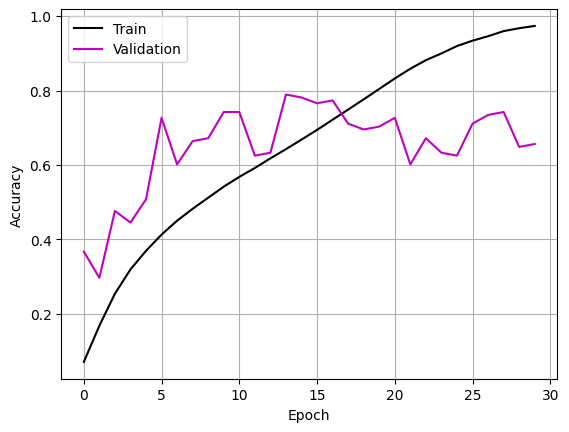

In [17]:
plt.plot(range(avg_epoch), acc_train_hist, 'k-', label='Train')
plt.plot(range(avg_epoch), acc_valid_hist, 'm-', label='Validation',)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [20]:
torch.save(model, 'C:\\Users\\User\\Documents\\GitHub\\Models-Build\\ResNet34-ImageNet-batchsize128-opt=SGD+lr=0.001.pth')